## Sequences of Multi-labelled data
Earlier we have examined the notion that documents can the thought of a sequence of tokens along with a mapping from a set of labels to these tokens.  Ideas like stemming and lemmatization are linguistic methods for applying different label mappings to these token sequences.  An example of this might be the sequence of tokens assocated with the sentence:
<pre>"the cats sat in the cat box"</pre>
This can be decomposed into the sequence of tokens:
<pre>[the, cats, sat, in, the, cat, box]</pre>
The notion of token and label are often confounded but it can be useful to keep them separated mentally.  Here we a sequence of six tokens _token_1_ through _token_6_ along with a single label assocated with each token.  In this case  _'the' $\mapsto$ token_1_ and _'the' $\mapsto$ token_5_.  They are different tokens with the same label.

We take advantage of these shared labels in our TokenCooccurrenceVectorizer where we embed token labels into a vector space based on the locality of their associated tokens within our sequence.  That is two labels are similar if their surrounding tokens share many common labels.  This is covered in more explicite detail in:

[TODO: Add Link to TokenCooccurrenceVectorizer readme](https://noteboook_link_here)

That said there is nothing which necessitates that we associate a single label with each token.  In fact, as we mentioned previously, stemming can be thought of as a way of contracting the label space by contracting a set of labels such as _(tabby, feline, cat, cats)_ to a single token label _(cat)_.  Traditionally in NLP, we would replace the label mapping for all the tokens previously associated with various feline tokens with our new canonical token _cat_.  This has the twin advantages of simplifying our label space, making it easier to analyse, and seeing more examples of _cat_ in our text, potentially improving the embedding of this label by providing more contexts in which it was used.  If we didn't care about simplifying our token space we could, in fact, get the second benefit without the first.  Instead of replacing our label mapping to each of these tokens we could instead map from a set of labels to each token instead of from a single labels.  Thus, in our previous example of *"the cats sat in the cat box"* _{cat, cats} $\mapsto$ token_2_.  

One oddity this introduces is that the contex of _sat_ now has both the labels _cat_ and _cats_ occuring at a distance of 1 from it.  This can become problematic if taken to extreme levels in that that very wide context windows when combined with large label sets could cause a combinatorial explosion.  When used in moderation this can be a powerful and quite useful technique in that it allows us a great deal of freedom when moving beyond the text domain to other sequence domains.  The other oddity that this can introduce is that the labels _cat_ and _cats_ now cooccur within a context window at distance zero from each other.  This has the nice property of encoding the label similarity that has been specified by our mapping int our embedding.  

A great example of the usefulness of this multi-label framework occurs when looking at the cyber defense domain. The [Operationally Transparent Cyber (OpTC)](https://github.com/FiveDirections/OpTC-data) data is a DARPA released data set that examines the sequence of computer events on a small network of computers and asks researchers to search for known malicious activity within these events.  More details on this dataset, it's content and utility for cyber defense analysis can be found in the recent paper [Analyzing the Usefulness of the DARPA OpTCDataset in Cyber Threat Detection Research](https://arxiv.org/pdf/2103.03080.pdf).  

The interesting thing for us to note is that this data was described as a **"sequence of events"**.  What differentiates cyber **events** from those **tokens** we spoke about in NLP?  The short answer is nothing other than the fact that they can't be easily represented by a single label.  Now we have a framework for representing such multi-labelled tokens or events.  Let's see what that might look like in practice.

Cyber events come in a variety of flavours.  The most common being FLOW events.  Flow event represent data being transmitted between two computers.  They are commonly summarized via a set of descriptions such as:

<pre>[process, source_IP, source_port, destination_IP, destination_port, protocal, time_stamp]</pre>

Here a process instantiated a connection from a source IP address and port to a destination IP address and port and sent data over that connection at a particular time.

Previously it might have been difficult to think about how we might apply something like a 
TokenCooccurrenceVectorizer to this sort of data but with our new notion of muli-labelled tokens we quickly realize that flow events are really just tokens with interesting labels associated with them and a sequence induced via our time_stamps.  This should allow us to embed these labels into a useful vector space with similar tokens being placed near other tokens that appear within the same event and have similar preceeding and following events.

Let's walk through a few increasingly more complex examples.

# Import Some libraries

We'll need TokenCooccurrenceVectorizer from our vectorizers library along with a few helper functions for dealing with our data and plotting it.

In [1]:
from vectorizers import TokenCooccurrenceVectorizer
from vectorizers.utils import flatten

import pandas as pd
import numpy as np
import umap
import umap.plot

We'll add some bokeh imports for easy interactive plots

In [2]:
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

# Let's fetch some data

The OpTC data is a bit difficult to pull and parse into easy to process formats.  I will leave that as an excercise to the reader.  A colleague of ours has pulled this data and restructured it into parquet files distributed across a nice file structure but that is outside of the scope of this notebook.  

For the purposes of this notebook we will load simple pandas data frames that were derived from this events data.  Each event is a row in one of these data frames and we have wide set of columns representing all of the summary labels that one might use to represent our various types of cyber events.

In order for this example to be easily reproducable on a reasonably small machine we we limit our initial analysis to one days worth of FLOW MESSAGE data on a single host.  This is for demonstration purposes only and a useful analysis of this data should be broadened to incorporate more of this data.

In [4]:
flows_onehost_oneday = pd.read_csv("optc_flows_onehost_oneday.csv")
flows_onehost_oneday.shape

(1066972, 60)

In [5]:
flows_onehost_oneday.columns

Index(['action', 'actorID', 'id', 'object', 'objectID', 'pid', 'ppid',
       'principal', 'tid', 'acuity_level', 'base_address', 'command_line',
       'context_info', 'data', 'dest_ip', 'dest_port', 'direction', 'end_time',
       'file_path', 'image_path', 'info_class', 'key', 'l4protocol',
       'logon_id', 'module_path', 'name', 'new_path', 'parent_image_path',
       'path', 'payload', 'privileges', 'requesting_domain',
       'requesting_logon_id', 'requesting_user', 'service_type', 'sid', 'size',
       'src_ip', 'src_pid', 'src_port', 'src_tid', 'stack_base', 'stack_limit',
       'start_address', 'start_time', 'start_type', 'subprocess_tag',
       'task_name', 'task_pid', 'task_process_uuid', 'tgt_pid', 'tgt_pid_uuid',
       'tgt_tid', 'type', 'user', 'user_name', 'user_stack_base',
       'user_stack_limit', 'value', 'timestamp'],
      dtype='object')

You'll notice that we have just over a million events that are being desribed by a wide variety of descriptive columns.  Since we've limited our data to network flow data many of these columns aren't populated for this particular data set.  For a more detailed description of this data and these fields I point a reader to the paper we mentioned earlier,  [Analyzing the Usefulness of the DARPA OpTCDataset in Cyber Threat Detection Research](https://arxiv.org/pdf/2103.03080.pdf). 

For the purposes of this notebook we are most interested in:

<pre>[process, source_IP, source_port, destination_IP, destination_port, protocal, time_stamp]</pre>

In this data these correspond to the fields:

<pre>['image_path', 'src_ip', 'src_port','dest_ip', 'dest_port', 'l4protocol', 'timestamp']</pre>

In [6]:
flow_variables = ['image_path', 'src_ip', 'src_port','dest_ip', 'dest_port', 'l4protocol']
categorical_variables = flow_variables 
sort_by = ['timestamp']

# Restructure our data

Now we need to restructure this data into a format for easy consumption via our TokenCooccurrenceVectorizer.

We will convert each row of our data_frame into a sequence of multi-labelled events.  To do that we'll need to convert from a list of categorical column values into a a list of labels.  An easy way to define a label associated with a categorical column is in the form of the string <code>f'{column_name}:{value}'</code>.

We'll first ensure that our events are propperyl ordered by time

In [7]:
flows_sorted = flows_onehost_oneday.sort_values(by = 'timestamp')

Now we limit ourselves to the columns of interest for these particular events.

In [8]:
flows_df = flows_sorted[flows_sorted.columns.intersection(categorical_variables)]
flows_df.shape

(1066972, 6)

In [9]:
flows_df.head(3)

,dest_ip,dest_port,image_path,l4protocol,src_ip,src_port
486928,142.20.56.121,54564,\Device\HarddiskVolume1\Windows\system32\svcho...,17,142.20.61.130,53
85558,224.0.0.252,5355,\Device\HarddiskVolume1\Windows\system32\svcho...,17,142.20.59.60,63450
54700,224.0.0.252,5355,\Device\HarddiskVolume1\Windows\system32\svcho...,17,142.20.57.70,56722


Now we'll quickly iterate through this dataframe and into our list of lists format.

In [10]:
def categorical_columns_to_list(data_frame, column_names):
    """
    Takes a data frame and a set of columns and represents each row a list of the appropriate non-empty columns
    of the form column_name:value.
    """
    label_list = pd.Series([[f'{k}:{v}' for k, v in zip(column_names, t) if v is not None]
     for t in zip(*map(data_frame.get, column_names))])
    return label_list

In [11]:
flow_labels = categorical_columns_to_list(flows_df, categorical_variables)
len(flow_labels)

1066972

In [12]:
flow_labels[0]

['image_path:\\Device\\HarddiskVolume1\\Windows\\system32\\svchost.exe',
 'src_ip:142.20.61.130',
 'src_port:53',
 'dest_ip:142.20.56.121',
 'dest_port:54564',
 'l4protocol:17']

# TokenCooccurrenceVectorizer

We initially only embed labels that occur at least 20 times within our days events.  This prevents us from attempting to embed labels that we have very limited data for.  

We will initally select a <code>window_radii=2</code> in order to include some very limited sequence information.  The presumption here is that the flow messages that occurred near each other in the sequence of flow events are related to each other.

Lastly we set <code>multi_labelled_tokens=True</code> to convey that we are dealing with a sequence of multi-labelled events.

In [13]:
word_vectorizer = TokenCooccurrenceVectorizer(
    min_occurrences= 20,
    window_radii=2,
    multi_labelled_tokens=True).fit(flow_labels)
word_vectors = word_vectorizer.reduce_dimension()

print(f"This constructs an embedding of {word_vectorizer.cooccurrences_.shape[0]} labels represented by their",
      f"cooccurrence with {word_vectorizer.cooccurrences_.shape[1]} labels occurring before and after them.\n",
      f"We have then reduced this space to a {word_vectors.shape[1]} dimensional representation.")

This constructs an embedding of 15014 labels represented by their cooccurrence with 30028 labels occurring before and after them.
 We have then reduced this space to a 150 dimensional representation.


For the purposes of visualization we will use our UMAP algorithm to embed this data into two dimensional space.

In [14]:
model = umap.UMAP(n_neighbors=30, metric='cosine', unique=True, random_state=42).fit(word_vectors)

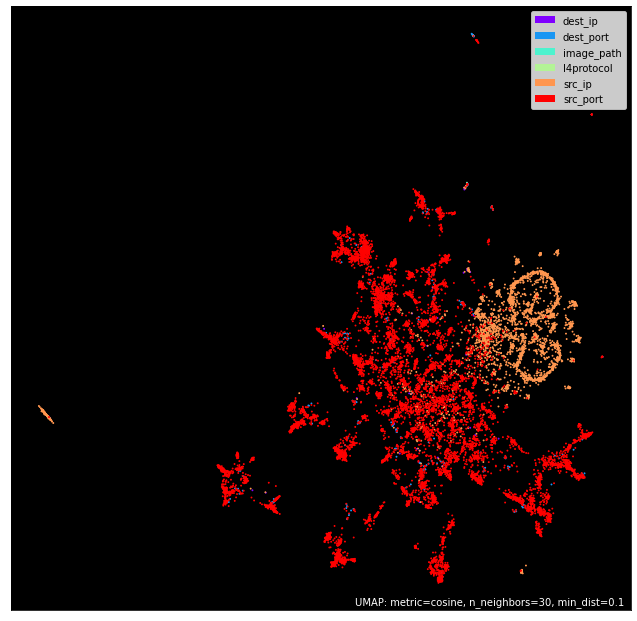

In [15]:
hover_df = pd.DataFrame({'label':word_vectorizer.token_label_dictionary_.keys()})
event_type = hover_df.label.str.split(':', n=1, expand=True)
event_type.columns = ['type','value']
umap.plot.points(model, theme='fire', labels=event_type['type']);

A little exploration of this space quickly reveals that our label space is overwhelmed by source ports (and some destination ports with values in the range 40,000 to 60,000.  A little consultation with subject matter experts quickly reveals that these are so called ephemeral ports.  That is a pre-established range of ports that are used to establish temporary connections and then thrown away to be re-used by other processes later.  The disposable nature of these ports explains why there is such a plethora of them within our label space.  In fact what we see here are clusters of these ports that are all used by the same process and IP pairs over the course of our day.  

Though it's encouraging that we can easily detect this structure it is essentially meaningless structure since it tells us nothing about the flows or processes and is completely unstable over any period of time.  As such we will want to remove these tokens from our space.

Fortunately TokenCooccurrenceVectorizer() has an <code>exclude_token_regex</code> parameter which will allow us to remove these tokens with very little work.

In [16]:
word_vectorizer = TokenCooccurrenceVectorizer(
    min_occurrences= 20,
    window_radii=2,
    excluded_token_regex='(src\_port|dest\_port):[4-6][0-9]{4}',
    multi_labelled_tokens=True).fit(flow_labels)
word_vectors = word_vectorizer.reduce_dimension()

print(f"This constructs an embedding of {word_vectorizer.cooccurrences_.shape[0]} labels represented by their",
      f"cooccurrence with {word_vectorizer.cooccurrences_.shape[1]} labels occurring before and after them.\n",
      f"We have then reduced this space to a {word_vectors.shape[1]} dimensional representation.")

This constructs an embedding of 3245 labels represented by their cooccurrence with 6490 labels occurring before and after them.
 We have then reduced this space to a 150 dimensional representation.


As before we'll reduce this 150 dimensional representation to a two dimensional representation for visualization and exploration.  Since we are already using subject matter knowledge to enrich our analysis we will continue in this vein and label our IP addresses with whether they are internal or external addresses.  Internal IP addresses are of the form <code>10.\*.\*.\*</code>.

In [17]:
model = umap.UMAP(n_neighbors=30, metric='cosine', unique=True, random_state=42).fit(word_vectors)

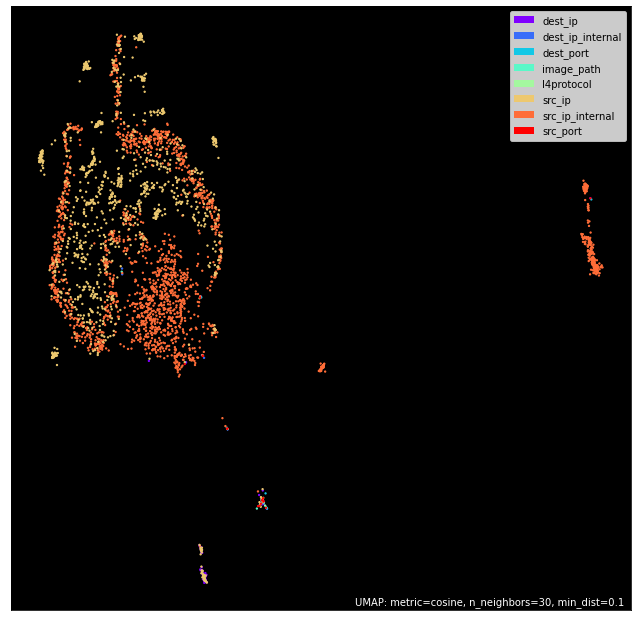

In [18]:
hover_df = pd.DataFrame({'label':word_vectorizer.token_label_dictionary_.keys()})
internal_bool = hover_df.label.str.contains("ip:10\.")
event_type = hover_df.label.str.split(':', n=1, expand=True)
event_type.columns = ['type','value']
event_type['type'][internal_bool] = event_type['type'][internal_bool] + '_internal'
umap.plot.points(model, theme='fire', labels=event_type['type']);

This provides a nice structure over our token label space.  We see and can interesting mixtures of internal and external source IP spaces with connections making use of specific source and destination ports seperating off nicely into their own clusters.

The next step would be to look at your data by building an interactive plot and starting to exploring these clusters in earnest.

In [19]:
p = umap.plot.interactive(model, theme='fire', labels=event_type['type'], hover_data=hover_df, point_size=3, width=600, height=600)
umap.plot.show(p)